# Agricultural dataset
---
In this notebook, we train a image classification algorithms to classify images from the Agricultural-crops dataset.


<img src='notebook_ims/cifar_data.png' width=50% height=50% />

### Test for [CUDA](http://pytorch.org/docs/stable/cuda.html)

Since these are larger (32x32x3) images, it may prove useful to speed up your training time by using a GPU. CUDA is a parallel computing platform and CUDA Tensors are the same as typical Tensors, only they utilize GPU's for computation.

In [1]:
# Import libraries
import torch
import numpy as np

# PyTorch dataset
from torchvision import datasets
import torchvision.transforms as transforms

# PyTorch model
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


In [2]:
torch.cuda.is_available()

True

In [3]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()
 
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [4]:
!nvidia-smi

Tue Jul  2 07:11:23 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 546.24                 Driver Version: 546.24       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4060 ...  WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   40C    P4              17W /  55W |      0MiB /  8188MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

---
## Load the [Data](https://pytorch.org/vision/stable/datasets.html)

Downloading may take a minute. We load in the training and test data, split the training data into a training and validation set, then create DataLoaders for each of these sets of data.

In [5]:
import os
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

In [6]:
current_working_directory  = Path.cwd()
data_path = current_working_directory.parent / "data" / "Agricultural-crops"
new_data_path = data_path.parent / "Agricultural-crops-new"

In [7]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


image_datasets = {x: datasets.ImageFolder(new_data_path / x,
                                          data_transforms[x])
                  for x in ['train', 'valid', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=20,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'valid', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid', 'test']}
class_names = image_datasets['train'].classes


# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
dataset_sizes

{'train': 648, 'valid': 73, 'test': 108}

In [9]:
def feature_engineering(data_path):
    data_transforms = {
        'train': transforms.Compose([
            transforms.RandomResizedCrop(256),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'valid': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(256),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'test': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(256),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }


    image_datasets = {x: datasets.ImageFolder(data_path / x,
                                            data_transforms[x])
                    for x in ['train', 'valid', 'test']}
    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=20,
                                                shuffle=True, num_workers=0)
                for x in ['train', 'valid', 'test']}
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid', 'test']}
    class_names = image_datasets['train'].classes
    return image_datasets, dataloaders, dataset_sizes, class_names

image_datasets, dataloaders, dataset_sizes, class_names = feature_engineering(new_data_path)
train_loader, valid_loader, test_loader = dataloaders['train'], dataloaders['valid'], dataloaders['test']

In [78]:
from abc import ABC, abstractmethod
import torch.nn.functional as F
from torchvision.models import vgg16, resnet50, googlenet, efficientnet_v2_s
import pytorch_lightning as pl
from torchmetrics.functional import accuracy
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.loggers import TensorBoardLogger


models_dict = {
    'vgg16': vgg16,
    'resnet50': resnet50,
    'googlenet': googlenet,
    'efficientnet_v2_s': efficientnet_v2_s
}


class BasePretrainedModel(ABC):
    @abstractmethod
    def __init__(self, model_name, pretrained, num_classes):
        pass

    def freeze_features(self):
        """Freezes the training for all feature layers."""
        for param in self.model.parameters():
            param.requires_grad = False

    @abstractmethod
    def adapt_last_layer(self, num_classes):
        """
        Adapts the last layer of the model for the given number of classes.
        
        Args:
            num_classes (int): The number of output classes.
        """
        pass


class PretrainedModel(BasePretrainedModel):
    def __init__(self, model_name, pretrained=True, num_classes=30):
        # Load model
        self.model_name = model_name
        self.model = models_dict[self.model_name](pretrained=pretrained)
        self.freeze_features()
        self.adapt_last_layer(num_classes=num_classes)

        if torch.cuda.is_available():
            self.model.cuda()
    
    def adapt_last_layer(self, num_classes):

        if self.model_name in ['vgg16', 'efficientnet_v2_s']:
            n_inputs = self.model.classifier[-1].in_features
            last_layer = nn.Linear(n_inputs, num_classes)
            self.model.classifier[-1] = last_layer
        else:
            n_inputs = self.model.fc.in_features
            last_layer = nn.Linear(n_inputs, num_classes)
            self.model.fc = last_layer

class CNN_agri(nn.Module):
    def __init__(self):
        super(CNN_agri, self).__init__()
        # convolutional layer (sees 256x256x3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # convolutional layer (sees 126x128x16 tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # convolutional layer (sees 64x64x32 tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer (64 * 32 * 32 -> 262144)
        self.fc1 = nn.Linear(64 * 32 * 32, 40)
        # linear layer (262144 -> 30)
        self.fc2 = nn.Linear(40, 30)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.05)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # flatten image input
        x = x.view(-1, 64 * 32 * 32)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        # x = F.softmax(self.fc2(x))
        x = self.fc2(x)
        return x


In [79]:
class PretrainedModelLightning(pl.LightningModule):
    def __init__(self, model_name):
        super(PretrainedModelLightning, self).__init__()
        if model_name == 'own':
            self.model = CNN_agri()
        else:
            pre_model = PretrainedModel(model_name=model_name, pretrained=True, num_classes=30)
            self.model = pre_model.model

    def forward(self, x):
        out = self.model(x)
        return F.log_softmax(out, dim=1)

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=0.01)
    
    def cross_entropy_loss(self, output, target):
        return F.nll_loss(output, target)
    
    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        output = self.forward(x)
        loss = self.cross_entropy_loss(output, y)
        preds = torch.argmax(output, dim=1)
        acc = accuracy(preds, y, task='multiclass', num_classes=len(class_names))
        self.log('train_acc', acc,prog_bar=True)
        self.log('train_loss', loss, prog_bar=True)
        return loss

    def evaluate(self, batch, stage=None):
        x, y = batch
        logits = self(x)
        loss = self.cross_entropy_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = accuracy(preds, y, task='multiclass', num_classes=len(class_names))

        if stage:
            self.log(f"{stage}_loss", loss, prog_bar=True)
            self.log(f"{stage}_acc", acc, prog_bar=True)

    def validation_step(self, batch, batch_idx):
        self.evaluate(batch, "val")

    def test_step(self, batch, batch_idx):
        self.evaluate(batch, "test")
    

In [94]:
model_name = 'vgg16'
model = PretrainedModelLightning(model_name=model_name)

trainer = pl.Trainer(
    max_epochs=5,
    accelerator="auto",
    devices=1 if torch.cuda.is_available() else None,  # limiting got iPython runs
    # logger=CSVLogger(save_dir="logs/"),
    callbacks=[LearningRateMonitor(logging_interval="step"), TQDMProgressBar(refresh_rate=2)],
    logger=TensorBoardLogger("tb_logs", name='agricultural')
)

trainer.fit(
    model,
    train_loader,
    valid_loader
)


c:\Users\luisg\Documents\projects\cifar-CNN\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\luisg\Documents\projects\cifar-CNN\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\luisg\Documents\projects\cifar-CNN\.venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:475: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
c:\Users\luisg\Documents\projects\cifar-CNN\.venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


c:\Users\luisg\Documents\projects\cifar-CNN\.venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
c:\Users\luisg\Documents\projects\cifar-CNN\.venv\lib\site-packages\pytorch_lightning\loops\fit_loop.py:298: The number of training batches (33) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 4: 100%|██████████| 33/33 [00:08<00:00,  3.83it/s, v_num=1, train_acc=1.000, train_loss=0.0499, val_loss=2.190, val_acc=0.726]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 33/33 [00:10<00:00,  3.21it/s, v_num=1, train_acc=1.000, train_loss=0.0499, val_loss=2.190, val_acc=0.726]


In [95]:
trainer.validate(model, dataloaders=valid_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 4/4 [00:00<00:00,  4.90it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.7260273694992065     │
│         val_loss          │    2.1936140060424805     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 2.1936140060424805, 'val_acc': 0.7260273694992065}]

In [96]:
trainer.test(model, dataloaders=test_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\luisg\Documents\projects\cifar-CNN\.venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:475: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
c:\Users\luisg\Documents\projects\cifar-CNN\.venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 6/6 [00:01<00:00,  4.93it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7129629850387573     │
│         test_loss         │     1.917876124382019     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 1.917876124382019, 'test_acc': 0.7129629850387573}]

In [92]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [54]:
# !rm -rf ./lightning_logs/version_0/

In [93]:
%tensorboard --logdir C:/Users/luisg/Documents/projects/cifar-CNN/notebooks/tb_logs/agricultural//

In [ ]:
## TODO improve tensorboard metrics

In [56]:
# !kill 18092

### Visualize a Batch of Training Data

In [23]:
import pandas as pd

data_path = Path.cwd().parent / "data" / "Agricultural-crops-new"
_, dataloaders, dataset_sizes, class_names = feature_engineering(data_path)
train_loader, valid_loader, test_loader = dataloaders['train'], dataloaders['valid'], dataloaders['test']

In [26]:
loaded_model = torch.load('../mlartifacts/1/8bde21ab9c214e2ba624b6ae8974fd20/artifacts/models/data/model.pth')
loaded_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [27]:
from PIL import Image

In [28]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [40]:
def pytorch_predict(im):
    loaded_model.eval()
    transformed_image = transform(im).unsqueeze(0)

    prediction = loaded_model(transformed_image.cuda()).squeeze(0).softmax(0)

    class_id = prediction.argmax().item()
    score = prediction.max().item()

    return class_names[class_id], score


def prueba_predict(im):
    transformed_image = transform(im).unsqueeze(0)
    loaded_model = CNN_agri().cuda()
    prediction = loaded_model(transformed_image.cuda()).squeeze(0).softmax(0)
    print(prediction)
    class_id = prediction.argmax().item()
    score = prediction.max().item()

    return class_names[class_id], score


(168, 300, 3)


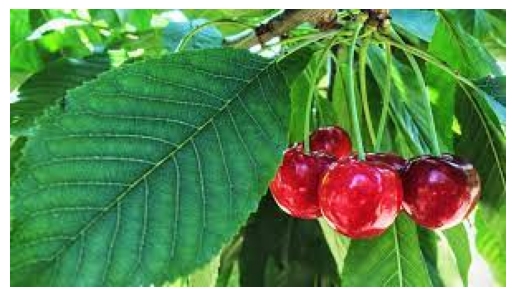

('Cherry', 0.720136821269989)
tensor([0.0317, 0.0374, 0.0353, 0.0310, 0.0367, 0.0350, 0.0280, 0.0295, 0.0306,
        0.0370, 0.0314, 0.0289, 0.0368, 0.0318, 0.0293, 0.0366, 0.0329, 0.0322,
        0.0361, 0.0285, 0.0339, 0.0350, 0.0355, 0.0300, 0.0380, 0.0375, 0.0368,
        0.0294, 0.0309, 0.0364], device='cuda:0', grad_fn=<SoftmaxBackward0>)
('sugarcane', 0.03796720504760742)


In [41]:
# open method used to open different extension image file 
# im = Image.open(r"C:/Users/luisg/documents/projects/cifar-CNN/data/Agricultural-crops-new/test/banana/image (14).jpg")
# im = Image.open(r"C:/Users/luisg/documents/projects/cifar-CNN/data/Agricultural-crops-new/test/Lemon/image20.jpeg")
# im = Image.open(r"C:/Users/luisg/documents/projects/cifar-CNN/data/Agricultural-crops-new/test/Lemon/images34.jpg")
im = Image.open(r"C:/Users/luisg/documents/projects/cifar-CNN/data/Agricultural-crops-new/test/Cherry/image22.jpeg")

# Convert the PIL image to a NumPy array
np_img = np.array(im)
# Display the image using Matplotlib
print(np_img.shape)
plt.imshow(np_img)
plt.axis('off')  # Hide the axis
plt.show()

# print(mlflow_predict(im))
print(pytorch_predict(im))
print(prueba_predict(im))